# COMP47670 Data Science in Python (Mixed Delivery)
# Assignment 2: Text Classification

Name : Aquif Inamdar

Student Number : 18200043

The objective of this assignment is to scrape consumer reviews from a web pages and evaluate the performance of text classification on the data.
For this assignment I have used reviews from **Automotive** and **Health and Science** category.

## Import Packages 

In [0]:
import pandas as pd
import numpy as np
import bs4
import urllib
import re
import itertools

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics,svm
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from nltk.stem import WordNetLemmatizer
from string import digits

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import operator
from collections import Counter

%matplotlib inline

Links for the categories

In [0]:
link = "http://mlg.ucd.ie/modules/yalp"
automotive_link = "http://mlg.ucd.ie/modules/yalp/automotive_list.html"
health_link = "http://mlg.ucd.ie/modules/yalp/health_medical_list.html"

Set of functions used in the code

In [0]:
"""This function will get all the links present on web page
Input : Page url
Output : List of all the links present on page"""
def getLinks(url):
    html_page = urllib.request.urlopen(url)
    soup = bs4.BeautifulSoup(html_page)
    links = []
 
    for link in soup.findAll('a', attrs={'href': re.compile(".html")}):
        links.append(link.get('href'))
 
    return links

"""This function convert list of list to single list"""
def flat_list(rrlist):
    return list(itertools.chain.from_iterable(rrlist))

"""This function will call get_reviews and get_rating function and return reviews and ratings
Input : URL of the page to get reviews and rating
Output : 2 Lists one for reviews and another for ratings"""
def get_reviews_ratings(url):
    review = []
    rating = []

    links = getLinks(url)
    for review_link in links:
        review.append(get_review(link+"/"+review_link))
        rating.append(get_rating(link+"/"+review_link))
    
    return flat_list(review),convert_numto_pos_neg(flat_list(rating))

"""This fuction will get all the reviews present on the web page
Input : URl
Output : list of reviews"""
def get_review(url):
    html_page = urllib.request.urlopen(url)
    soup = bs4.BeautifulSoup(html_page)
    reviews = []
         
    for txt in soup.findAll('p', attrs={'class': "text"}):
        reviews.append(txt.get_text())
    
    return reviews

"""This fuction will get all the ratings present on the web page
Input : URl
Output : list of ratings"""
def get_rating(url):
    html_page = urllib.request.urlopen(url)
    soup = bs4.BeautifulSoup(html_page)    
    ratings = []     

    for star in soup.findAll('img', attrs={'alt': re.compile(r"\d+")}):
        ratings.append(int(star.get('alt')[0]))
 
    return ratings

"""This function will convert the number of stars ratings to positive or negative
 Starts 1-3 means negative review
 Starts 4-5 means positive review
"""
def convert_numto_pos_neg(rating):
    return(['positive' if (rat > 3) else 'negative' for rat in rating ])

"""This function will remove numbers and short words(i.e words having length less than 3)
This function will also perform lemmatization(convert words to root form)
Input : review
Output : processed reviews """
def remove_num_shotwords(review):    
    tokenize = CountVectorizer().build_tokenizer()
    tok_rev = tokenize(review)

    lemmatizer = WordNetLemmatizer()
    lem_rev = []
    for word in tok_rev:
        remove_digits = str.maketrans('', '', digits)
        word = word.translate(remove_digits).strip()
        if word!='':            
            lem_rev.append(lemmatizer.lemmatize(word,'v'))
    lem_rev = ' '.join(lem_rev)
    lem_rev = ' '.join(word for word in lem_rev.split() if len(word)>3)
    
    return lem_rev

"""This function is used when a custom function is to be used in a pipeline.
remove_num_shotwords function is used in pipeline for processing reviews """
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

"""This function will create a pipeline i.e series of steps to be performed on reviews to convert them into matrix of features.
Input : classifier name and vectorizer(Tfidf/BOW)
Output : pipeline
"""
def create_pipeline(classifier,vectorizer):
    
    if vectorizer == 'Tfidf':
        vectorizer = TfidfVectorizer(analyzer='word',stop_words="english", min_df = 5)
    elif vectorizer == 'BOW':
        vectorizer = CountVectorizer(stop_words="english", min_df = 5)
    
    pipeline = Pipeline([
     ('remove num & shotwords',pipelinize(remove_num_shotwords)),
     ('vectorizer', vectorizer), 
     ('dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
     ('classifier', classifier)
    ])
    
    return pipeline

### Task-1 Scrapping all the reviews from Automotive and Health and Science category

In [0]:
#Create empty data frame one for each category
automotive_reviews_ratings=pd.DataFrame()
health_reviews_ratings=pd.DataFrame()

#Get the reviews and rating and store in data frame
automotive_reviews_ratings['review'], automotive_reviews_ratings['rating'] = get_reviews_ratings(automotive_link)
health_reviews_ratings['review'], health_reviews_ratings['rating'] = get_reviews_ratings(health_link)        

Check the data 

In [5]:
automotive_reviews_ratings.head()

,review,rating
0,I arrived at 3 PM and the dealership closed at...,positive
1,I dropped my car off on a Wednesday morning fo...,negative
2,My parents have been buying cars off of Donna ...,positive
3,I recently bought another car from Donna Dunni...,positive
4,I had to schedule an appointment due to the ai...,positive


In [6]:
health_reviews_ratings.head()

,review,rating
0,I have so many good things to say about this p...,positive
1,I found them to be highly skilled and an exper...,positive
2,Where do I even begin? This office has been so...,positive
3,I went in because I had toothache and needed a...,positive
4,Found a new dental office. This place is amazi...,positive


Store the data in .csv file

In [0]:
#One .csv file for each category
automotive_reviews_ratings.to_csv("Automotive.csv",index = None)
health_reviews_ratings.to_csv("Health.csv",index = None)

### Task-2 Preprocessing or reviews to create a numeric representation of the data, Build a classification model and Test the predictions of the classification model

For this task I have created a **pipeline** which will perform following steps:
1. Remove the numbers and short words i.e words having length less the 3 from the reviews
2. Vectorize the reviews either in Bag-of-words document-term matrix or Tfidf. While vectorizing remove stopwords and words that dont appear in more than 5 documents i.e 5 reviews.
3. Classify the text with appropriate classification algorithm.

For this assignment I have used both **CountVectorizer()** and **TfidfVectorizer()** to check which vectorizer will give better result.
I have used **K-nn, Naive Bayes and SVM** classifier for classification

Basic Steps for each classifier are:
1. Create a **pipeline** with specified classifier and vectorizer
2. Perform a **GridSearch**
3. **Fit** the model with best parameters found
4. Make **predictions** on fitted model
5. Calculate **accuracy** and display **confusion matrix**

To find which vectorizer is better I have first used Tfidfvectorizer and ran on all the classifiers and noted the accuracy for each and i have performed same with Bag-of-words

In [0]:
# Dictionary to store the accuracy from different classifier
Tfidf_model_accuracy = {} # Store accuracy for different classifier with vectorizer = TfidfVectorizer
Tfidf_model_accuracy_fold = {} # Store accuracy for grid search for different classifier with vectorizer = TfidfVectorizer
BOW_model_accuracy = {}   # Store accuracy for different classifier with vectorizer = CountVectorizer
BOW_model_accuracy_fold = {}   # Store accuracy for grid search for different classifier with vectorizer = CountVectorizer

In [0]:
#Read the stored file of Automotive
automotive_reviews_ratings = pd.read_csv('Automotive.csv')
#Read the stored file of Health
health_reviews_ratings = pd.read_csv('Health.csv')

## Vectorizer Tfidf

### Category : Automotive

In [0]:
# Split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(automotive_reviews_ratings['review'],automotive_reviews_ratings['rating'],train_size=0.7)


#### Classifier : K-nn & Vectorizer : Tfidf

Grid Search

In [11]:
# Create pipeline 
pipeline = create_pipeline(KNeighborsClassifier(),'Tfidf')

#Grid parameters
parama = {'classifier__n_neighbors': [3,4,6,9,11],
           'classifier__weights': ['uniform','distance'],
           'classifier__metric': ['euclidean','manhattan']}

#Perform GridSearch
model_knn = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit model on best parameter
model_knn.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_knn.best_params_)

# Make a set of predictions for the test data
y_pred = model_knn.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
Tfidf_model_accuracy["Automotive-Knn"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 11,
 'classifier__weights': 'distance'}

Accuracy: 0.8352402745995423
              precision    recall  f1-score   support

    negative       0.87      0.57      0.69       140
    positive       0.83      0.96      0.89       297

   micro avg       0.84      0.84      0.84       437
   macro avg       0.85      0.77      0.79       437
weighted avg       0.84      0.84      0.82       437

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,80,60,140
positive,12,285,297
All,92,345,437


5-fold cross validation

In [12]:
#Classifier
clf = KNeighborsClassifier(metric= "euclidean", n_neighbors= 11, weights= "distance")
#Create pipeline
pipeline = create_pipeline(clf,'Tfidf')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,automotive_reviews_ratings['review'],automotive_reviews_ratings['rating'] , cv=5)
#Store the mean score 
Tfidf_model_accuracy_fold["Automotive-Knn"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.75684932 0.69178082 0.68041237 0.75862069 0.80344828]
Mean accuracy 0.7382222947275128


#### Classifier : Naive Bayes & Vectorizer : Tfidf

Grid Search

In [13]:
#Create pipeline
pipeline = create_pipeline(MultinomialNB(),'Tfidf')

#Grid parameters
parama = {'classifier': [MultinomialNB(),GaussianNB()]}

#Perform GridSearch
model_nb = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit model on best parameters
model_nb.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_nb.best_params_)

# Make a set of predictions for the test data
y_pred = model_nb.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
Tfidf_model_accuracy["Automotive-NaiveBayes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

Accuracy: 0.8535469107551488
              precision    recall  f1-score   support

    negative       0.97      0.56      0.71       140
    positive       0.83      0.99      0.90       297

   micro avg       0.85      0.85      0.85       437
   macro avg       0.90      0.78      0.81       437
weighted avg       0.87      0.85      0.84       437

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,78,62,140
positive,2,295,297
All,80,357,437


5-fold cross validation

In [14]:
#Classifier
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
#Create pipeline
pipeline = create_pipeline(clf,'Tfidf')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,automotive_reviews_ratings['review'],automotive_reviews_ratings['rating'] , cv=5)
#Store the mean score 
Tfidf_model_accuracy_fold["Automotive-NaiveBayes"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.83219178 0.81164384 0.83505155 0.82413793 0.88965517]
Mean accuracy 0.8385360532556769


#### Classifier : SVM & Vectorizer : Tfidf

Grid Search

In [15]:
#Create pipeline
pipeline = create_pipeline(svm.SVC(),'Tfidf')
#Grid Parameters
parama = {'classifier__kernel': ['linear'],
           'classifier__C': [1, 10]}

#Perform GridSearch
model_svm = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit model on best parameters
model_svm.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_svm.best_params_)

# Make a set of predictions for the test data
y_pred = model_svm.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
Tfidf_model_accuracy["Automotive-SVM"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__C': 1, 'classifier__kernel': 'linear'}

Accuracy: 0.8901601830663616
              precision    recall  f1-score   support

    negative       0.86      0.79      0.82       140
    positive       0.90      0.94      0.92       297

   micro avg       0.89      0.89      0.89       437
   macro avg       0.88      0.86      0.87       437
weighted avg       0.89      0.89      0.89       437

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,110,30,140
positive,18,279,297
All,128,309,437


5-fold cross validation

In [16]:
#Classifier
clf = svm.SVC(C= 1, kernel='linear')
#Create pipeline
pipeline = create_pipeline(clf,'Tfidf')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,automotive_reviews_ratings['review'],automotive_reviews_ratings['rating'] , cv=5)
#Store the mean score 
Tfidf_model_accuracy_fold["Automotive-SVM"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.87671233 0.88013699 0.86597938 0.84827586 0.88965517]
Mean accuracy 0.8721519461989102


### Category : Health and Science

In [0]:
#split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(health_reviews_ratings['review'],health_reviews_ratings['rating'],train_size=0.7)


#### Classifier : K-nn & Vectorizer : Tfidf

Grid Search

In [18]:
#Create pipeline
pipeline = create_pipeline(KNeighborsClassifier(),'Tfidf')
#Grid Parameters
parama = {'classifier__n_neighbors': [3,4,6,9,11],
           'classifier__weights': ['uniform','distance'],
           'classifier__metric': ['euclidean','manhattan']}

#Perform GridSearch
model_knn = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit model on best parameters
model_knn.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_knn.best_params_)

# Make a set of predictions for the test data
y_pred = model_knn.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
Tfidf_model_accuracy["Health-Knn"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 11,
 'classifier__weights': 'distance'}

Accuracy: 0.841743119266055
              precision    recall  f1-score   support

    negative       0.75      0.55      0.63       108
    positive       0.86      0.94      0.90       328

   micro avg       0.84      0.84      0.84       436
   macro avg       0.80      0.74      0.77       436
weighted avg       0.83      0.84      0.83       436

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,59,49,108
positive,20,308,328
All,79,357,436


5-fold cross validation

In [19]:
#Classifier
clf = KNeighborsClassifier(metric= "euclidean", n_neighbors= 11, weights= "distance")
#Create pipeline
pipeline = create_pipeline(clf,'Tfidf')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,health_reviews_ratings['review'],health_reviews_ratings['rating'] , cv=5)
#Store the mean score 
Tfidf_model_accuracy_fold["Health-Knn"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.80756014 0.81443299 0.84137931 0.83044983 0.80622837]
Mean accuracy 0.820010127636927


#### Classifier : Naive Bayes & Vectorizer : Tfidf

Grid Search

In [20]:
#Create pipeline
pipeline = create_pipeline(MultinomialNB(),'Tfidf')

#Grid parameters
parama = {'classifier': [MultinomialNB(),GaussianNB()]}

#Perform GridSearch
model_nb = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit model
model_nb.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_nb.best_params_)

# Make a set of predictions for the test data
y_pred = model_nb.predict(x_test)



# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
Tfidf_model_accuracy["Health-NaiveBayes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

Accuracy: 0.8807339449541285
              precision    recall  f1-score   support

    negative       0.95      0.55      0.69       108
    positive       0.87      0.99      0.93       328

   micro avg       0.88      0.88      0.88       436
   macro avg       0.91      0.77      0.81       436
weighted avg       0.89      0.88      0.87       436

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,59,49,108
positive,3,325,328
All,62,374,436


5-fold cross validation

In [21]:
#Classifier
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
#Create pipeline
pipeline = create_pipeline(clf,'Tfidf')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,health_reviews_ratings['review'],health_reviews_ratings['rating'] , cv=5)
#Store the mean score 
Tfidf_model_accuracy_fold["Health-NaiveBayes"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.87285223 0.89347079 0.85517241 0.84083045 0.85467128]
Mean accuracy 0.8633994335903784


#### Classifier : SVM & Vectorizer : Tfidf

Grid Search

In [22]:
#Create pipeline
pipeline = create_pipeline(svm.SVC(),'Tfidf')
#Grid parameters
parama = {'classifier__kernel': ['linear'],
           'classifier__C': [1, 10]}

#Perform GridSearch
model_svm = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit model
model_svm.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_svm.best_params_)

# Make a set of predictions for the test data
y_pred = model_svm.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
Tfidf_model_accuracy["Health-SVM"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__C': 1, 'classifier__kernel': 'linear'}

Accuracy: 0.9220183486238532
              precision    recall  f1-score   support

    negative       0.86      0.81      0.84       108
    positive       0.94      0.96      0.95       328

   micro avg       0.92      0.92      0.92       436
   macro avg       0.90      0.89      0.89       436
weighted avg       0.92      0.92      0.92       436

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,88,20,108
positive,14,314,328
All,102,334,436


5-fold cross validation

In [23]:
#Classifier
clf = svm.SVC(C= 1, kernel='linear')
#Create pipeline
pipeline = create_pipeline(clf,'Tfidf')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,health_reviews_ratings['review'],health_reviews_ratings['rating'] , cv=5)
#Store the mean score 
Tfidf_model_accuracy_fold["Health-SVM"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.91408935 0.91752577 0.89655172 0.89965398 0.88581315]
Mean accuracy 0.9027267944881053


Train Test Split Results

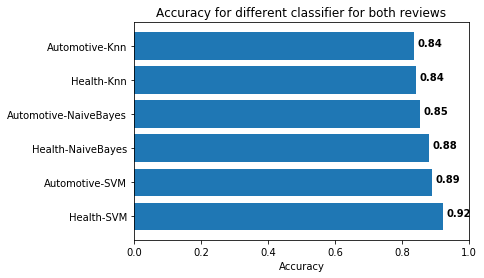

In [24]:
Tfidf_model_accuracy = sorted(Tfidf_model_accuracy.items(), key=operator.itemgetter(1),reverse=True)
Tfidf_model_accuracy = dict(Tfidf_model_accuracy)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(Tfidf_model_accuracy)), list(Tfidf_model_accuracy.values()), align='center')
_ = plt.yticks(range(len(Tfidf_model_accuracy)), list(Tfidf_model_accuracy.keys()))
_ = plt.xlabel('Accuracy')
_ = plt.title('Accuracy for different classifier for both reviews')
for i, v in enumerate(list(Tfidf_model_accuracy.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()


5-fold cross validation results

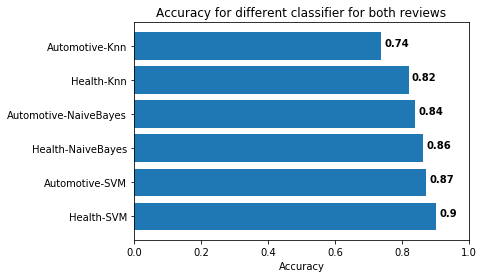

In [25]:
Tfidf_model_accuracy_fold = sorted(Tfidf_model_accuracy_fold.items(), key=operator.itemgetter(1),reverse=True)
Tfidf_model_accuracy_fold = dict(Tfidf_model_accuracy_fold)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(Tfidf_model_accuracy_fold)), list(Tfidf_model_accuracy_fold.values()), align='center')
_ = plt.yticks(range(len(Tfidf_model_accuracy_fold)), list(Tfidf_model_accuracy_fold.keys()))
_ = plt.xlabel('Accuracy')
_ = plt.title('Accuracy for different classifier for both reviews')
for i, v in enumerate(list(Tfidf_model_accuracy_fold.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()


It can be observed from the above graph that accuracy of **SVM** model is good for both category of reviews with vectorizer  **Tfidf**

## Bag-of-Words

### Category : Automotive

#### Classifier : K-nn & Vectorizer : CountVectorizer or Bag-of-Words

Grid Search

In [26]:
#Split the data 
x_train, x_test, y_train, y_test = train_test_split(automotive_reviews_ratings['review'],automotive_reviews_ratings['rating'],train_size=0.7)

#create pipeline
pipeline = create_pipeline(KNeighborsClassifier(),'BOW')
#Grid parameters
parama = {'classifier__n_neighbors': [3,4,6,9,11],
           'classifier__weights': ['uniform','distance'],
           'classifier__metric': ['euclidean','manhattan']}

#Perform GridSearch
model_knn = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit model
model_knn.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_knn.best_params_)

# Make a set of predictions for the test data
y_pred = model_knn.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
BOW_model_accuracy["Automotive-Knn"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 11,
 'classifier__weights': 'distance'}

Accuracy: 0.7368421052631579
              precision    recall  f1-score   support

    negative       0.86      0.18      0.29       135
    positive       0.73      0.99      0.84       302

   micro avg       0.74      0.74      0.74       437
   macro avg       0.79      0.58      0.57       437
weighted avg       0.77      0.74      0.67       437

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,24,111,135
positive,4,298,302
All,28,409,437


5-fold cross validation

In [27]:
#Classifier
clf = KNeighborsClassifier(metric= "manhattan", n_neighbors= 11, weights= "distance")
#Create pipeline
pipeline = create_pipeline(clf,'BOW')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,automotive_reviews_ratings['review'],automotive_reviews_ratings['rating'] , cv=5)
#Store the mean score 
BOW_model_accuracy_fold["Automotive-Knn"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.69520548 0.73287671 0.72164948 0.72758621 0.71724138]
Mean accuracy 0.7189118525047602


#### Classifier : Naive Bayes & Vectorizer : CountVectorizer or Bag-of-Words

Grid Search

In [28]:
#Create pipeline
pipeline = create_pipeline(MultinomialNB(),'BOW')

#Grid Parameters
parama = {'classifier': [MultinomialNB(),GaussianNB()]}

#Perform GridSearch
model_nb = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit the model
model_nb.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_nb.best_params_)

# Make a set of predictions for the test data
y_pred = model_nb.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
BOW_model_accuracy["Automotive-NaiveBayes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

Accuracy: 0.919908466819222
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87       135
    positive       0.94      0.94      0.94       302

   micro avg       0.92      0.92      0.92       437
   macro avg       0.91      0.91      0.91       437
weighted avg       0.92      0.92      0.92       437

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,118,17,135
positive,18,284,302
All,136,301,437


5-fold cross validation

In [29]:
#Classifier
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
#Create pipeline
pipeline = create_pipeline(clf,'BOW')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,automotive_reviews_ratings['review'],automotive_reviews_ratings['rating'] , cv=5)
#Store the mean score 
BOW_model_accuracy_fold["Automotive-NaiveBayes"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.89726027 0.91438356 0.84536082 0.87586207 0.89655172]
Mean accuracy 0.885883690692431


#### Classifier : SVM& Vectorizer : CountVectorizer or Bag-of-Words

Grid Search

In [30]:
#Create Pipeline
pipeline = create_pipeline(svm.SVC(),'BOW')
#Grid parameters
parama = {'classifier__kernel': ['linear'],
           'classifier__C': [1, 10]}

#Perform GridSearch
model_svm = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit the model
model_svm.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_svm.best_params_)

# Make a set of predictions for the test data
y_pred = model_svm.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
BOW_model_accuracy["Automotive-SVM"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__C': 1, 'classifier__kernel': 'linear'}

Accuracy: 0.8901601830663616
              precision    recall  f1-score   support

    negative       0.82      0.83      0.82       135
    positive       0.92      0.92      0.92       302

   micro avg       0.89      0.89      0.89       437
   macro avg       0.87      0.87      0.87       437
weighted avg       0.89      0.89      0.89       437

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,112,23,135
positive,25,277,302
All,137,300,437


5-fold cross validation

In [31]:
#Classifier
clf = svm.SVC(C= 1, kernel='linear')
#Create pipeline
pipeline = create_pipeline(clf,'BOW')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,automotive_reviews_ratings['review'],automotive_reviews_ratings['rating'] , cv=5)
#Store the mean score 
BOW_model_accuracy_fold["Automotive-SVM"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.85273973 0.84589041 0.86254296 0.84827586 0.86896552]
Mean accuracy 0.8556828943246213


### Category : Health and Science

#### Classifier : K-nn & Vectorizer : CountVectorizer or Bag-of-Words

Grid Search

In [32]:
#Split data 
x_train, x_test, y_train, y_test = train_test_split(health_reviews_ratings['review'],health_reviews_ratings['rating'],train_size=0.7)

#Create Pipline
pipeline = create_pipeline(KNeighborsClassifier(),'BOW')
#Grid Parameters
parama = {'classifier__n_neighbors': [3,4,6,9,11],
           'classifier__weights': ['uniform','distance'],
           'classifier__metric': ['euclidean','manhattan']}

#Perform GridSearch
model_knn = GridSearchCV(pipeline, parama, scoring='roc_auc')

#Fit the model
model_knn.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_knn.best_params_)

# Make a set of predictions for the test data
y_pred = model_knn.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
BOW_model_accuracy["Health-Knn"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 11,
 'classifier__weights': 'distance'}

Accuracy: 0.7247706422018348
              precision    recall  f1-score   support

    negative       0.82      0.07      0.13       127
    positive       0.72      0.99      0.84       309

   micro avg       0.72      0.72      0.72       436
   macro avg       0.77      0.53      0.48       436
weighted avg       0.75      0.72      0.63       436

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,9,118,127
positive,2,307,309
All,11,425,436


5-fold cross validation

In [33]:
#Classifier
clf = KNeighborsClassifier(metric= "euclidean", n_neighbors= 11, weights= "distance")
#Create pipeline
pipeline = create_pipeline(clf,'BOW')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,health_reviews_ratings['review'],health_reviews_ratings['rating'] , cv=5)
#Store the mean score 
BOW_model_accuracy_fold["Health-Knn"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.74226804 0.73883162 0.73103448 0.76124567 0.74740484]
Mean accuracy 0.7441569316294302


#### Classifier : Naive Bayes & Vectorizer : CountVectorizer or Bag-of-Words

Grid Search

In [34]:
pipeline = create_pipeline(MultinomialNB(),'BOW')


parama = {'classifier': [MultinomialNB(),GaussianNB()]}


model_nb = GridSearchCV(pipeline, parama, scoring='roc_auc')
model_nb.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_nb.best_params_)

# Make a set of predictions for the test data
y_pred = model_nb.predict(x_test)



# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
BOW_model_accuracy["Health-NaiveBayes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

Accuracy: 0.9105504587155964
              precision    recall  f1-score   support

    negative       0.83      0.87      0.85       127
    positive       0.94      0.93      0.94       309

   micro avg       0.91      0.91      0.91       436
   macro avg       0.89      0.90      0.89       436
weighted avg       0.91      0.91      0.91       436

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,110,17,127
positive,22,287,309
All,132,304,436


5-fold cross validation

In [35]:
#Classifier
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
#Create pipeline
pipeline = create_pipeline(clf,'BOW')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,health_reviews_ratings['review'],health_reviews_ratings['rating'] , cv=5)
#Store the mean score 
BOW_model_accuracy_fold["Health-NaiveBayes"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.91752577 0.91065292 0.9137931  0.89619377 0.85467128]
Mean accuracy 0.8985673699018932


#### Classifier : SVM& Vectorizer : CountVectorizer or Bag-of-Words

Grid Search

In [36]:
pipeline = create_pipeline(svm.SVC(),'BOW')

parama = {'classifier__kernel': ['linear'],
           'classifier__C': [1, 10]}


model_svm = GridSearchCV(pipeline, parama, scoring='roc_auc')
model_svm.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_svm.best_params_)

# Make a set of predictions for the test data
y_pred = model_svm.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
BOW_model_accuracy["Health-SVM"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__C': 1, 'classifier__kernel': 'linear'}

Accuracy: 0.9128440366972477
              precision    recall  f1-score   support

    negative       0.84      0.87      0.85       127
    positive       0.94      0.93      0.94       309

   micro avg       0.91      0.91      0.91       436
   macro avg       0.89      0.90      0.90       436
weighted avg       0.91      0.91      0.91       436

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,110,17,127
positive,21,288,309
All,131,305,436


5-fold cross validation

In [37]:
#Classifier
clf = svm.SVC(C= 1, kernel='linear')
#Create pipeline
pipeline = create_pipeline(clf,'BOW')
#Perform 5 fold cross validation
scores = cross_val_score(pipeline,health_reviews_ratings['review'],health_reviews_ratings['rating'] , cv=5)
#Store the mean score 
BOW_model_accuracy_fold["Health-SVM"] = scores.mean()

print("Accuracy for 5 folds",scores)
print("Mean accuracy",scores.mean())

Accuracy for 5 folds [0.90721649 0.88316151 0.89310345 0.87543253 0.8650519 ]
Mean accuracy 0.8847931768428916


Train-Test Split Results

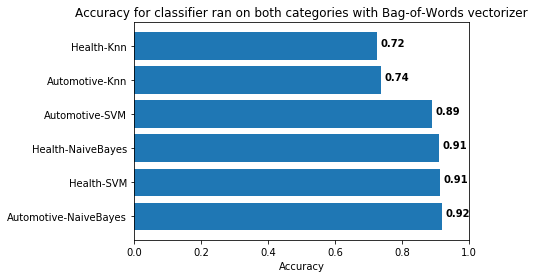

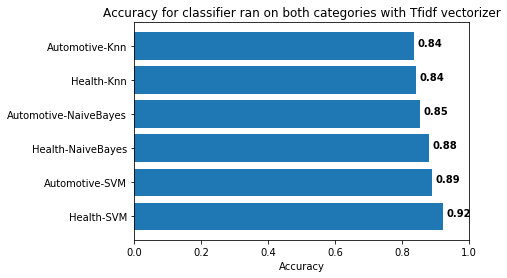

In [38]:
BOW_model_accuracy = sorted(BOW_model_accuracy.items(), key=operator.itemgetter(1),reverse=True)
BOW_model_accuracy = dict(BOW_model_accuracy)


plt.xlim(0, 1.0)
_ = plt.barh(range(len(BOW_model_accuracy)), list(BOW_model_accuracy.values()), align='center')
_ = plt.yticks(range(len(BOW_model_accuracy)), list(BOW_model_accuracy.keys()))
_ = plt.xlabel('Accuracy')
_ = plt.title('Accuracy for classifier ran on both categories with Bag-of-Words vectorizer')
for i, v in enumerate(list(BOW_model_accuracy.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()

Tfidf_model_accuracy = sorted(Tfidf_model_accuracy.items(), key=operator.itemgetter(1),reverse=True)
Tfidf_model_accuracy = dict(Tfidf_model_accuracy)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(Tfidf_model_accuracy)), list(Tfidf_model_accuracy.values()), align='center')
_ = plt.yticks(range(len(Tfidf_model_accuracy)), list(Tfidf_model_accuracy.keys()))
_ = plt.xlabel('Accuracy')
_ = plt.title('Accuracy for classifier ran on both categories with Tfidf vectorizer')
for i, v in enumerate(list(Tfidf_model_accuracy.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()


5-fold cross validation results

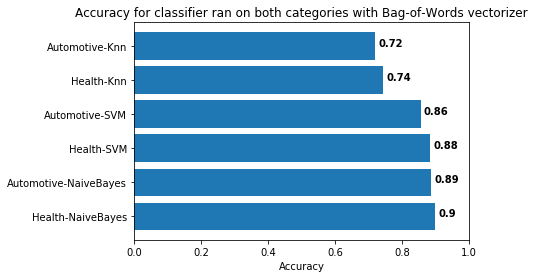

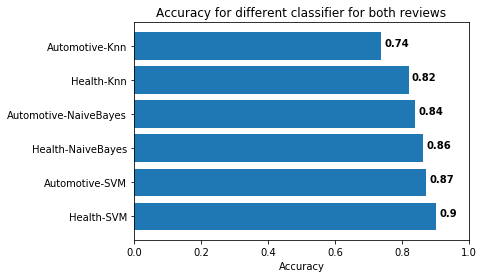

In [39]:
BOW_model_accuracy_fold = sorted(BOW_model_accuracy_fold.items(), key=operator.itemgetter(1),reverse=True)
BOW_model_accuracy_fold = dict(BOW_model_accuracy_fold)


plt.xlim(0, 1.0)
_ = plt.barh(range(len(BOW_model_accuracy_fold)), list(BOW_model_accuracy_fold.values()), align='center')
_ = plt.yticks(range(len(BOW_model_accuracy_fold)), list(BOW_model_accuracy_fold.keys()))
_ = plt.xlabel('Accuracy')
_ = plt.title('Accuracy for classifier ran on both categories with Bag-of-Words vectorizer')
for i, v in enumerate(list(BOW_model_accuracy_fold.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()


Tfidf_model_accuracy_fold = sorted(Tfidf_model_accuracy_fold.items(), key=operator.itemgetter(1),reverse=True)
Tfidf_model_accuracy_fold = dict(Tfidf_model_accuracy_fold)

plt.xlim(0, 1.0)
_ = plt.barh(range(len(Tfidf_model_accuracy_fold)), list(Tfidf_model_accuracy_fold.values()), align='center')
_ = plt.yticks(range(len(Tfidf_model_accuracy_fold)), list(Tfidf_model_accuracy_fold.keys()))
_ = plt.xlabel('Accuracy')
_ = plt.title('Accuracy for different classifier for both reviews')
for i, v in enumerate(list(Tfidf_model_accuracy_fold.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()


Train-Test split Results of classifier with different vetorizer combined in single graph

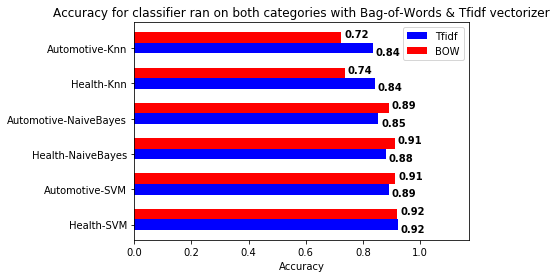

In [63]:
plt.xlim(0, 1.17)
X = np.arange(len(Tfidf_model_accuracy))
plt.barh(X + 0.00, list(Tfidf_model_accuracy.values()), color = 'b', label = 'Tfidf',height = 0.30)
plt.barh(X + 0.30, list(BOW_model_accuracy.values()), color = 'r', label = 'BOW',height = 0.30)
plt.yticks(range(len(Tfidf_model_accuracy)), list(Tfidf_model_accuracy.keys()))
plt.xlabel('Accuracy')
plt.title('Accuracy for classifier ran on both categories with Bag-of-Words & Tfidf vectorizer')
plt.legend()
for i, v in enumerate(list(BOW_model_accuracy.values())):
    a=round(v,2)
    plt.text(v+0.01 , i+0.3 , str(a), color='black', fontweight='bold')
for i, v in enumerate(list(Tfidf_model_accuracy.values())):
    a=round(v,2)
    plt.text(v+0.01 , i-0.2 , str(a), color='black', fontweight='bold')
plt.show()

5-fold cross validation Results of classifier with different vetorizer combined in single graph

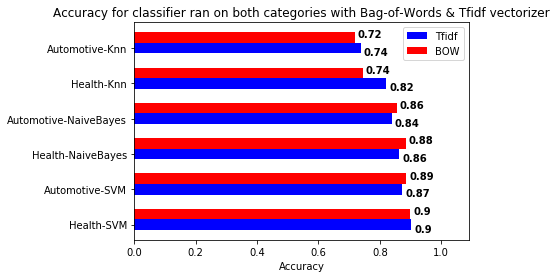

In [41]:
plt.xlim(0, 1.09)
X = np.arange(len(Tfidf_model_accuracy_fold))
plt.barh(X + 0.00, list(Tfidf_model_accuracy_fold.values()), color = 'b', label = 'Tfidf',height = 0.30)
plt.barh(X + 0.30, list(BOW_model_accuracy_fold.values()), color = 'r', label = 'BOW',height = 0.30)
plt.yticks(range(len(Tfidf_model_accuracy_fold)), list(Tfidf_model_accuracy_fold.keys()))
plt.xlabel('Accuracy')
plt.title('Accuracy for classifier ran on both categories with Bag-of-Words & Tfidf vectorizer')
plt.legend()
for i, v in enumerate(list(BOW_model_accuracy_fold.values())):
    a=round(v,2)
    plt.text(v+0.01 , i+0.3 , str(a), color='black', fontweight='bold')
for i, v in enumerate(list(Tfidf_model_accuracy_fold.values())):
    a=round(v,2)
    plt.text(v+0.01 , i-0.2 , str(a), color='black', fontweight='bold')
plt.show()

Get the distribution of class(positive or negative reviews) for both categories

In [42]:
print(Counter(automotive_reviews_ratings['rating']).keys())
Counter(automotive_reviews_ratings['rating']).values()

dict_keys(['positive', 'negative'])


dict_values([973, 482])

In [43]:
print(Counter(health_reviews_ratings['rating']).keys()) 
Counter(health_reviews_ratings['rating']).values()

dict_keys(['positive', 'negative'])


dict_values([1043, 407])

It can be observed Tfidf vectorizer has performed very well for classifiers where bag-of-word did not perform good. In remaining classifiers Tfidf has performed considerably well but Bag-of-words vectorizer is getting more accuracy for some classifier. The reason is that there are **few examples** to calibrate Tfidf. To check which vectorizer is better i have merged both the categories reviews into one list and now will use this data for classification.

In [0]:
#Merge reviews from both categories into single list
automotive_health_reviews = list(automotive_reviews_ratings['review']) + list(health_reviews_ratings['review'])
automotive_health_ratings = list(automotive_reviews_ratings['rating']) + list(health_reviews_ratings['rating'])

In [0]:
automotive_health = {}
automotive_health_fold = {}

#### Classifier : K-nn & Vectorizer : Tfidf

In [46]:
#Split data
x_train, x_test, y_train, y_test = train_test_split(automotive_health_reviews,automotive_health_ratings,train_size=0.7)

#Create pipeline
pipeline = create_pipeline(KNeighborsClassifier(),'Tfidf')
#Grid parameters
parama = {'classifier__n_neighbors': [3,4,6,9,11],
           'classifier__weights': ['uniform','distance'],
           'classifier__metric': ['euclidean','manhattan']}

#GridSearch
model_knn = GridSearchCV(pipeline, parama, scoring='roc_auc')
#Fit model
model_knn.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_knn.best_params_)

# Make a set of predictions for the test data
y_pred = model_knn.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
automotive_health["tfidf-Knn"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__metric': 'euclidean',
 'classifier__n_neighbors': 11,
 'classifier__weights': 'distance'}

Accuracy: 0.7970183486238532
              precision    recall  f1-score   support

    negative       0.85      0.47      0.60       287
    positive       0.79      0.96      0.86       585

   micro avg       0.80      0.80      0.80       872
   macro avg       0.82      0.71      0.73       872
weighted avg       0.81      0.80      0.78       872

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,134,153,287
positive,24,561,585
All,158,714,872


#### Classifier : Naive Bayes & Vectorizer : Tfidf

In [47]:
pipeline = create_pipeline(MultinomialNB(),'Tfidf')


parama = {'classifier': [MultinomialNB(),GaussianNB()]}


model_nb = GridSearchCV(pipeline, parama, scoring='roc_auc')
model_nb.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_nb.best_params_)

# Make a set of predictions for the test data
y_pred = model_nb.predict(x_test)



# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
automotive_health["tfidf-NaiveBayes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

Accuracy: 0.8658256880733946
              precision    recall  f1-score   support

    negative       0.97      0.61      0.75       287
    positive       0.84      0.99      0.91       585

   micro avg       0.87      0.87      0.87       872
   macro avg       0.91      0.80      0.83       872
weighted avg       0.88      0.87      0.86       872

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,175,112,287
positive,5,580,585
All,180,692,872


#### Classifier : SVM & Vectorizer : Tfidf

In [48]:
pipeline = create_pipeline(svm.SVC(),'Tfidf')

parama = {'classifier__kernel': ['linear'],
           'classifier__C': [1, 10]}


model_svm = GridSearchCV(pipeline, parama, scoring='roc_auc')
model_svm.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_svm.best_params_)

# Make a set of predictions for the test data
y_pred = model_svm.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
automotive_health["tfidf-SVM"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__C': 1, 'classifier__kernel': 'linear'}

Accuracy: 0.9071100917431193
              precision    recall  f1-score   support

    negative       0.90      0.81      0.85       287
    positive       0.91      0.95      0.93       585

   micro avg       0.91      0.91      0.91       872
   macro avg       0.90      0.88      0.89       872
weighted avg       0.91      0.91      0.91       872

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,233,54,287
positive,27,558,585
All,260,612,872


#### Classifier : K-nn & Vectorizer : CountVectorizer or Bag-of-Words

In [49]:
pipeline = create_pipeline(KNeighborsClassifier(),'BOW')

parama = {'classifier__n_neighbors': [3,4,6,9,11],
           'classifier__weights': ['uniform','distance'],
           'classifier__metric': ['euclidean','manhattan']}


model_knn = GridSearchCV(pipeline, parama, scoring='roc_auc')
model_knn.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_knn.best_params_)

# Make a set of predictions for the test data
y_pred = model_knn.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
automotive_health["BOW-Knn"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__metric': 'manhattan',
 'classifier__n_neighbors': 11,
 'classifier__weights': 'distance'}

Accuracy: 0.6777522935779816
              precision    recall  f1-score   support

    negative       0.88      0.02      0.05       287
    positive       0.68      1.00      0.81       585

   micro avg       0.68      0.68      0.68       872
   macro avg       0.78      0.51      0.43       872
weighted avg       0.74      0.68      0.56       872

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,7,280,287
positive,1,584,585
All,8,864,872


#### Classifier : Naive Bayes & Vectorizer : CountVectorizer or Bag-of-Words

In [50]:
pipeline = create_pipeline(MultinomialNB(),'BOW')


parama = {'classifier': [MultinomialNB(),GaussianNB()]}


model_nb = GridSearchCV(pipeline, parama, scoring='roc_auc')
model_nb.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_nb.best_params_)

# Make a set of predictions for the test data
y_pred = model_nb.predict(x_test)



# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
automotive_health["BOW-NaiveBayes"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)}

Accuracy: 0.9059633027522935
              precision    recall  f1-score   support

    negative       0.85      0.87      0.86       287
    positive       0.94      0.92      0.93       585

   micro avg       0.91      0.91      0.91       872
   macro avg       0.89      0.90      0.89       872
weighted avg       0.91      0.91      0.91       872

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,251,36,287
positive,46,539,585
All,297,575,872


#### Classifier : SVM & Vectorizer : CountVectorizer or Bag-of-Words

In [51]:
pipeline = create_pipeline(svm.SVC(),'BOW')

parama = {'classifier__kernel': ['linear'],
           'classifier__C': [1, 10]}


model_svm = GridSearchCV(pipeline, parama, scoring='roc_auc')
model_svm.fit(x_train, y_train)
print("Best parameters set found on development set:")
display(model_svm.best_params_)

# Make a set of predictions for the test data
y_pred = model_svm.predict(x_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
automotive_health["BOW-SVM"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix")
pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Best parameters set found on development set:


{'classifier__C': 1, 'classifier__kernel': 'linear'}

Accuracy: 0.8899082568807339
              precision    recall  f1-score   support

    negative       0.84      0.82      0.83       287
    positive       0.91      0.92      0.92       585

   micro avg       0.89      0.89      0.89       872
   macro avg       0.88      0.87      0.87       872
weighted avg       0.89      0.89      0.89       872

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,236,51,287
positive,45,540,585
All,281,591,872


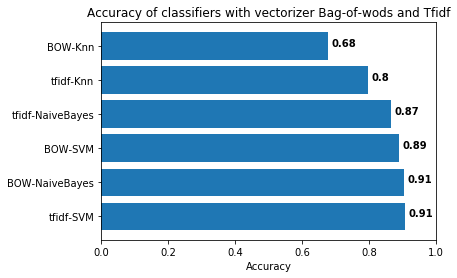

In [52]:
automotive_health = sorted(automotive_health.items(), key=operator.itemgetter(1),reverse=True)
automotive_health = dict(automotive_health)


plt.xlim(0, 1.0)
_ = plt.barh(range(len(automotive_health)), list(automotive_health.values()), align='center')
_ = plt.yticks(range(len(automotive_health)), list(automotive_health.keys()))
_ = plt.xlabel('Accuracy')
_ = plt.title('Accuracy of classifiers with vectorizer Bag-of-wods and Tfidf')
for i, v in enumerate(list(automotive_health.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()

It can be observed from the above graph that after combining the reviews from both categories Tfidf trained model got higher accuracy then Bag-Of-Words. This is because there were more examples to calibirate Tfidf.  

As there are less number of negative examples the classifiers are not able to classify negative examples that well then positive examples.
It can be observed from the above experiments that using **Tfidf vectorizer** is better option than using bag-of-words vectorizer. It can also be observed that **SVM** is the better classifier for the data, compared to other classifiers used in this experiment(i.e K-nn and Naive Bayes). 

## Task-3 How well two classification models transfer between category.

There are 2 part of this task:
1. In this we will train SVM classifier on Automotive reviews and will test on Health and Science reviews.
2. In this we will train SVM classifier on Health and Science reviews and will test on Automotive reviews.

In [0]:
task3 = {} #to store the accuracy value

###  Train on automotive reviews and  test on Health and Science reviews.

In [59]:
#Train
x_train = automotive_reviews_ratings['review']
y_train = automotive_reviews_ratings['rating']

#Test
x_test = health_reviews_ratings['review']
y_test = health_reviews_ratings['rating']


pipeline = create_pipeline(svm.SVC(C=1,kernel='linear',probability=True),'Tfidf')

pipeline.fit(x_train,y_train)

#Store the features
automotive_features = pipeline.named_steps['vectorizer'].get_feature_names()

#Make prediction
predicted = pipeline.predict(x_test)

accuracy = metrics.accuracy_score(y_test, predicted) # , normalize=True, sample_weight=None

task3['Train_on_automotive_test_on_health'] = accuracy

print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, predicted))

print("Confusion Matrix")
pd.crosstab(np.array(y_test), predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.9006896551724138
              precision    recall  f1-score   support

    negative       0.86      0.77      0.81       407
    positive       0.92      0.95      0.93      1043

   micro avg       0.90      0.90      0.90      1450
   macro avg       0.89      0.86      0.87      1450
weighted avg       0.90      0.90      0.90      1450

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,315,92,407
positive,52,991,1043
All,367,1083,1450


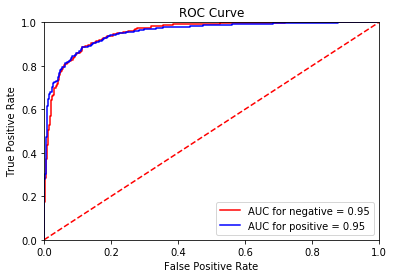

In [55]:
#ROC curve
probs = pipeline.predict_proba(x_test)
preds = probs[:,0]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label='negative')
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC for negative = %0.2f' % roc_auc,color = 'r')

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label='positive')
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC for positive = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Train on Automotive reviews and Test on Health and Science reviews.

In [60]:
#Train
x_train = health_reviews_ratings['review']
y_train = health_reviews_ratings['rating']

#Test
x_test = automotive_reviews_ratings['review']
y_test = automotive_reviews_ratings['rating']

pipeline = create_pipeline(svm.SVC(C=1,kernel='linear',probability=True),'Tfidf')

pipeline.fit(x_train,y_train)

#Store the features
health_features = pipeline.named_steps['vectorizer'].get_feature_names()

#Make predictions
predicted = pipeline.predict(x_test)

accuracy = metrics.accuracy_score(y_test, predicted) # , normalize=True, sample_weight=None
task3['Train_on_health_test_on_automotive'] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, predicted))

print("Confusion Matrix")
pd.crosstab(np.array(y_test), predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy: 0.8810996563573883
              precision    recall  f1-score   support

    negative       0.83      0.80      0.82       482
    positive       0.90      0.92      0.91       973

   micro avg       0.88      0.88      0.88      1455
   macro avg       0.87      0.86      0.86      1455
weighted avg       0.88      0.88      0.88      1455

Confusion Matrix


Predicted,negative,positive,All
True,,,
negative,387,95,482
positive,78,895,973
All,465,990,1455


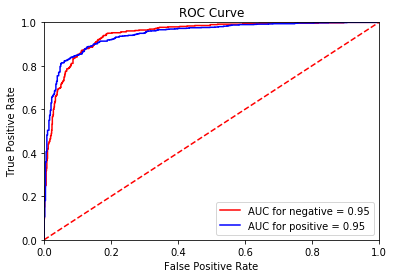

In [57]:
#ROC - Curve 
probs = pipeline.predict_proba(x_test)

preds = probs[:,0]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label='negative')
roc_auc = metrics.auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC for negative = %0.2f' % roc_auc,color = 'r')

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label='positive')
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC for positive = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


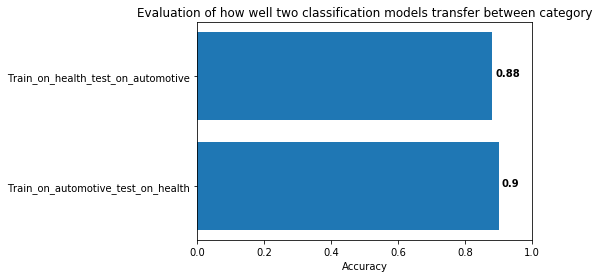

In [58]:
plt.xlim(0, 1.0)
_ = plt.barh(range(len(task3)), list(task3.values()), align='center')
_ = plt.yticks(range(len(task3)), list(task3.keys()))
plt.title('Evaluation of how well two classification models transfer between category')
plt.xlabel('Accuracy')
for i, v in enumerate(list(task3.values())):
    a=round(v,2)
    plt.text(v+0.01 , i , str(a), color='black', fontweight='bold')
plt.show()

In [61]:
#Features common in both categories reviews
len(list(set(automotive_features).intersection(health_features)))

962

It can be observed that for both of the above cases classifier gives nearly same accuracy. In both cases as there are less number of negative examples in training there are more missclassified negative examples. Both have nearly same accuracy because there are many words common in both categories as it can be seen from the features that are common in both categories. 